In [30]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Import data and create datasets

As labels dos dados estão definidas tais que:
- Background: 0
- Sinal: 1

In [31]:
# Gather data
bkgd = pd.read_hdf("data/processed/Background.h5", key='bkgd')
fcnc = pd.read_hdf("data/processed/FCNC.h5", key="fcnc")
X_train = pd.concat([bkgd, fcnc])
del bkgd, fcnc

In [32]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_train.drop(columns="Label"), X_train["Label"], 
                                                    test_size=1/3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=40)

In [33]:
print(f"Train_size: {len(y_train)} | Val size: {len(y_val)} | Test_size: {len(y_test)}")

Train_size: 1480266 | Val size: 1480267 | Test_size: 1480267


In [34]:
# Get sample weights
train_weights = X_train["gen_weights"]
val_weights = X_val["gen_weights"]
test_weights = X_test["gen_weights"]

# Get samples
train_samples = X_train["Sample"]
val_samples = X_val["Sample"]
test_samples = X_test["Sample"]

# Get features
X_train = X_train.drop(["gen_weights", "Sample"], axis=1)
X_val = X_val.drop(["gen_weights", "Sample"], axis=1)
X_test = X_test.drop(["gen_weights", "Sample"], axis=1)

# Get class weights
# Class 0 (background) is the reference class, with weight 1
class_weights = {
    0: 1,
    1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])
}

In [35]:
print(f"X_train: {X_train.values.shape} | y_train: {y_train.values.shape} | train_weights: {train_weights.values.shape}")
print(f"X_val: {X_val.values.shape} | y_val: {y_val.values.shape} | val_weights: {val_weights.values.shape}")
print(f"X_test: {X_test.values.shape} | y_test: {y_test.values.shape} | test_weights: {test_weights.values.shape}")

X_train: (1480266, 69) | y_train: (1480266,) | train_weights: (1480266,)
X_val: (1480267, 69) | y_val: (1480267,) | val_weights: (1480267,)
X_test: (1480267, 69) | y_test: (1480267,) | test_weights: (1480267,)


In [36]:
# Save Validation Data
X_val.to_hdf("data/classifier/val_data.h5", key="X")
y_val.to_hdf("data/classifier/val_data.h5", key="y")
val_weights.to_hdf("data/classifier/val_data.h5", key="weights")

# Save Test Data
X_test.to_hdf("data/classifier/test_data.h5", key="X")
y_test.to_hdf("data/classifier/test_data.h5", key="y")
test_weights.to_hdf("data/classifier/test_data.h5", key="weights")

# Build the model

In [9]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_samples):
        self.means = np.mean(data_samples, axis=0, keepdims=True)
        self.stds = np.std(data_samples, axis=0, keepdims=True)
        
    def call(self, inputs):
        return (inputs - self.means) / (self.stds + keras.backend.epsilon())
    
std_layer = Standardization()
std_layer.adapt(X_train.values)

Tentar um modelo com menos complexidade e utilizar MC Dropout para tentar obter melhores resultados

In [10]:
inputs = keras.Input(shape=(69,))
standardize = std_layer(inputs)
fc1 = keras.layers.Dense(55, activation='relu')(inputs)
d1 = keras.layers.Dropout(0.1)(fc1, training=True)
fc2 = keras.layers.Dense(40, activation='relu')(d1)
d2 = keras.layers.Dropout(0.1)(fc2, training=True)
fc3 = keras.layers.Dense(25, activation='relu')(d2)
#d3 = keras.layers.Dropout(0.1)(fc3, training=True)
#fc4 = keras.layers.Dense(40, activation='relu')(d3)
outputs = keras.layers.Dense(1, activation='sigmoid')(fc3)
model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss="binary_crossentropy",
              metrics=["accuracy", keras.metrics.AUC()])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
dense (Dense)                (None, 55)                3850      
_________________________________________________________________
dropout (Dropout)            (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1025      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26    

In [8]:
# Model name
name = "HiddenDense:55,40,25|BatchS:512|Dropout:0.1"

# Callbacks 

In [13]:
# Tensorboard
TB = keras.callbacks.TensorBoard("logs/" + name, write_images=True)

# Early Stopping
ES = keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, verbose=2, mode="min")

# Model Checkpoint
MC = keras.callbacks.ModelCheckpoint("models/" + name + ".h5", save_best_only=True, monitor="val_loss",
                                     mode="min")

# Treinar modelo

O modelo tem uma AUC consideravelmente baixa

In [14]:
start = time.time()
history = model.fit(X_train.values, y_train.values, batch_size=512,
                    epochs=80, shuffle=True, validation_data=(X_val.values, y_val.values),
                    sample_weight=train_weights.values, class_weight=class_weights, 
                    callbacks=[TB, ES, MC])
end = time.time()
print(f"The training took {(end - start)/3600} hours")

Epoch 1/80
2892/2892 [==============================] - 28s 10ms/step - loss: 4.6892e-07 - accuracy: 0.9557 - auc: 0.5012 - val_loss: 1.3678 - val_accuracy: 0.9558 - val_auc: 0.5036
Epoch 2/80
2892/2892 [==============================] - 27s 9ms/step - loss: 8.0221e-08 - accuracy: 0.9561 - auc: 0.5057 - val_loss: 1.0838 - val_accuracy: 0.9558 - val_auc: 0.5009
Epoch 3/80
2892/2892 [==============================] - 27s 9ms/step - loss: 7.2969e-08 - accuracy: 0.9562 - auc: 0.5092 - val_loss: 0.7377 - val_accuracy: 0.9558 - val_auc: 0.5144
Epoch 4/80
2892/2892 [==============================] - 27s 9ms/step - loss: 5.5541e-08 - accuracy: 0.9562 - auc: 0.5173 - val_loss: 0.6479 - val_accuracy: 0.9558 - val_auc: 0.5231
Epoch 5/80
2892/2892 [==============================] - 28s 10ms/step - loss: 5.1357e-08 - accuracy: 0.9562 - auc: 0.5289 - val_loss: 0.5972 - val_accuracy: 0.9558 - val_auc: 0.5321
Epoch 6/80
2892/2892 [==============================] - 27s 9ms/step - loss: 4.8938e-08 - acc

### Loss with epochs - Best seen with TensorBoard

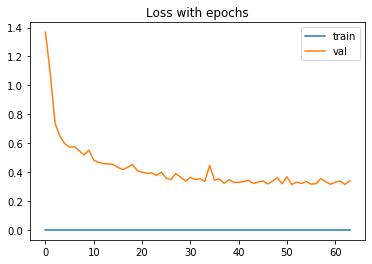

In [27]:
plt.title("Loss with epochs")
plt.plot(history.history["loss"], label='train')
plt.plot(history.history["val_loss"], label='val')
plt.legend()
plt.show()